In [2]:
import numpy as np
import glob
import os
import cPickle as pickle
from collections import defaultdict

import shapefile as shp
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import matplotlib.path as mplPath

import matplotlib.lines as mlines

import shutil
import seaborn as sns
from scipy.interpolate import interp1d

%matplotlib inline

In [3]:
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'in', 'xtick.major.size': 4.0, 'ytick.direction': 'in', 'ytick.major.size': 4.0, \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.})

In [4]:
# eppy paramters
from eppy import modeleditor
from eppy.modeleditor import IDF
# set the idd file to your own location
#iddfile = './Energy+.idd'
iddfile = 'Energy+.idd'
IDF.setiddname(iddfile)

get building occupancies from the building occupancy results folder

In [5]:
tracts = os.listdir('../PickledData/HyperlocalBuildings/')
tracts = [x.split('.')[0] for x in tracts if '.pickle' in x]
print tracts

['25025010702']


In [6]:
def get_building_occupancy_results(tracts, path_to_results):
    noOccupancy = [0 for j in range(11)]
    tractBuildingsProcessed = {}
    for t in tracts:
        with open(path_to_results+t+'.pickle', 'rb') as f:
            tractBuildingsProcessed[t] = pickle.load(f)
        for bId in tractBuildingsProcessed[t]:
            maxOccupancy = np.max(tractBuildingsProcessed[t][bId]['occupancy'], axis=1)
            tractBuildingsProcessed[t][bId]['max_occupancy'] = maxOccupancy
            tractBuildingsProcessed[t][bId]['fraction_occupied'] = \
            np.zeros(np.shape(tractBuildingsProcessed[t][bId]['occupancy']))
            for j,m in enumerate(maxOccupancy):
                if m>0:
                    tractBuildingsProcessed[t][bId]['fraction_occupied'][j] = \
                    tractBuildingsProcessed[t][bId]['occupancy'][j]/m
                else:
                    tractBuildingsProcessed[t][bId]['fraction_occupied'][j] = \
                    tractBuildingsProcessed[t][bId]['occupancy'][j]
                    noOccupancy[j]+=1

    print 'Number of buildings with no occupancy: ', noOccupancy

    # tractBuildingsProcessed is a dictionary of the tracts
    # Each tract tractBuildingsProcessed[t] is a dictionary of the buildings
    # Each building (tractBuildingsProcessed[t]['BuildingID']) has a BuildingID like 'Bos_2009698000_B0_M0'
    # Each tractBuildingsProcessed[t]['BuildingID'] is a dictionary containing the properties of the building
    return tractBuildingsProcessed


In [7]:
path = '../PickledData/BuildingOccupancy/'
tractBuildingsProcessed = get_building_occupancy_results(tracts, path)

Number of buildings with no occupancy:  [39, 47, 41, 50, 48, 47, 58, 59, 69, 74, 85]


In [8]:
# make a dictionary with all buildings in one place
tractBuildings = {}
for t in tracts:
    for b in tractBuildingsProcessed[t]:
        tractBuildings[b] = tractBuildingsProcessed[t][b]
tractBuildingsProcessed = None

In [9]:
# get all the object ids
allObjectIDs = []
for buildingID in tractBuildings:
    oId = buildingID.split('_')[0]
    if oId not in allObjectIDs:
        allObjectIDs.append( oId )

In [10]:
# get the different uses from the data input file (containing uses are areas for all objects)
with open('../Data/SDL_Buildings/BBXX_USEAREA_POL.txt', 'r') as f:
    first_line = f.readline()
    first_line = first_line.replace("\"", "")
    first_line = first_line.replace("A_", "")
    first_line = first_line.replace("\r\n", "")
    Uses = first_line.split(',')[6:]
    print Uses

['ATHLETIC', 'ACADEMIC', 'PUBLCASM', 'FIREPOL', 'GARAGE', 'HOTEL', 'LIBRARY', 'MALL', 'MEDICAL', 'MUSEUM', 'OFFICE', 'RESIDENT', 'RESTRNT', 'RETAIL', 'SUPERMRK', 'SCHOOL', 'WORSHIP']


In [11]:
# get the buildings where we have details, objectId and buildingId
areas = []
objectIDs = []
SDLIDs = []
with open('../Data/SDL_Buildings/BBXX_USEAREA_POL.txt', 'r') as f:
    first_line = f.readline()
    for line in f:
        line = line.replace("\"", "")
        line = line.replace("\r\n", "")
        line = line.split(',')
        # line[4] is polygon area and line[5] is tot floor area, floor ares per use start at line[6] for athletic
        b = []
        for a in line[6:]:
            b.append(float(a))
        areas.append(b)
        oId = line[0]
        if oId in allObjectIDs:
            objectIDs.append(line[0])
            SDLIDs.append(line[1])

In [12]:
# get the number of distinct uses (each of which has a nonzero area) for each shape
useNum = np.zeros(len(objectIDs))
for k,oId in enumerate(objectIDs):
    useInd = [j for j,a in enumerate(areas[k]) if a>0.1]
    useNum[k] = len(useInd)

In [13]:
# create a new dict (of dicts) for the SDL buildings and add occupancy for all objects
SDLBuildings = {}
for bID in SDLIDs:
    SDLBuildings[bID] = {}

In [14]:
for buildingID in tractBuildings:
    oId = buildingID.split('_')[0]
    # each building in all buildings has a unique id (the first part of the unique id is the object id) and unique use
    areaUse = tractBuildings[buildingID]['use']
    bId = SDLIDs[objectIDs.index(oId)]
    # Check if the SDL building already has that use 
    try:
        SDLBuildings[bId][areaUse]
    except:
        SDLBuildings[bId][areaUse] = {}
        SDLBuildings[bId][areaUse]['occupancy'] = np.zeros(np.shape(tractBuildings[buildingID]['occupancy']))
    # add the occupancy from that portion of the building
    SDLBuildings[bId][areaUse]['occupancy'] = SDLBuildings[bId][areaUse]['occupancy']+\
                                                tractBuildings[buildingID]['occupancy']
    SDLBuildings[bId]['geometry'] = tractBuildings[buildingID]['geometry']

In [15]:
def switch_occupancy_to_hourly(occupancy_10_min):
    # function to go from 10 min occupancy to hourly
    val = 6.
    i = 0
    count = 0
    total = 0.
    occNew = np.zeros((1,24))
    for slot10min in occupancy_10_min:
        total=float(slot10min)+total
        count=count+1
        if count%val==0:
            # sum every sixth and divide by six
            occNew[0,i] = np.round( (total/float(val)) )
            i += 1
            total=0.
    # the mobile occupancy starts with the slot 04.00-04.10
    myPerm = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3]
    i = np.argsort(myPerm)
    occNew = occNew[0,i]
    return occNew

In [16]:
for bId in SDLBuildings:
    for aU in [u for u in SDLBuildings[bId] if 'total' not in u and 'geo' not in u]:
        SDLBuildings[bId][aU]['occupancy24'] = np.zeros((11,24))
        for j in range(11):
            SDLBuildings[bId][aU]['occupancy24'][j] = \
            switch_occupancy_to_hourly(SDLBuildings[bId][aU]['occupancy'][j])
    uses = [a for a in SDLBuildings[bId].keys() if 'total' not in a and 'geo' not in a]
    occ = [SDLBuildings[bId][aU]['occupancy24'] for aU in uses]
    SDLBuildings[bId]['total_occupancy24'] = np.sum(occ, axis=0)

Look at idf files

In [17]:
# get a list of the idf files
fileList = glob.glob('../Full_idf_files/*_0.idf')
print len(fileList)

325


In [18]:
def get_use_to_occupancy(idfFile):   
    schedules = idfFile.idfobjects['SCHEDULE:YEAR']
    # this translates from the yearly schedule name in the 'people' object to the monday schedule name
    sYToD = {}
    for s in schedules:
        if 'Occ' in s.Name:
            sYToD[s.Name] = s.ScheduleWeek_Name_1
    schedules = idfFile.idfobjects['SCHEDULE:WEEK:DAILY']
    for sh in sYToD:
        name = sYToD[sh]
        for s in schedules:
            if name == s.Name:
                sYToD[sh] = s.Monday_ScheduleDay_Name
    # below goes from year schedule to 
    schedules = idfFile.idfobjects['SCHEDULE:DAY:HOURLY']
    sNamToNum = {}
    for sh in sYToD:
        name = sYToD[sh]
        for s in schedules:
            if name == s.Name:
                sNamToNum[s.Name] = s['obj'][3:]                
    # this then translates between a use and a monday schedule name
    sYToD2 = {}
    for key, val in sYToD.iteritems():
        sYToD2[key.split('B_')[1][0:4]] = val
    return sYToD2, sNamToNum     

In [20]:
# # do one pass through all files and get occupancy on a weekday
# allTestBuildings = {}
# for j,f in enumerate(fileList):
#     if j%100==0:
#         print j, 'buildings considered'
#     idf1 = IDF(f)
#     buildingID = f.split('files/')[1][:-4].split('_')[0]
#     allTestBuildings[buildingID] = {}
#     allTestBuildings[buildingID]['zoneAreas'] = []
#     allTestBuildings[buildingID]['zoneUses'] = []
#     allTestBuildings[buildingID]['peoplePerAreaZone'] = []
#     zoneObjects = idf1.idfobjects['ZONE']
#     people = idf1.idfobjects['PEOPLE']
#     schedules = idf1.idfobjects['SCHEDULE:YEAR']
    
#     allTestBuildings[buildingID]['useToSchedule'], allTestBuildings[buildingID]['occs'] \
#     = get_use_to_occupancy(idf1)
    
#     for j in range(len(people)):
#         allTestBuildings[buildingID]['zoneAreas'].append( zoneObjects[j].Floor_Area )
#         allTestBuildings[buildingID]['zoneUses'].append( people[j].Number_of_People_Schedule_Name.split('B_')[1][0:4] )
#         allTestBuildings[buildingID]['peoplePerAreaZone'].append( people[j].People_per_Zone_Floor_Area )
        
# for bId in allTestBuildings:
#     allTestBuildings[bId]['total_occupancy'] = np.zeros((24))
#     for j,z in enumerate(allTestBuildings[bId]['zoneUses']):
#         maxPeople = allTestBuildings[bId]['zoneAreas'][j]*allTestBuildings[bId]['peoplePerAreaZone'][j]
#         zoneSchedule = allTestBuildings[bId]['useToSchedule'][z]
#         zoneOccupancy = np.asarray( [x*maxPeople for x in allTestBuildings[bId]['occs'][zoneSchedule]] )
#         allTestBuildings[bId]['total_occupancy'] += zoneOccupancy
#     allTestBuildings[bId]['total_occupancy'] = np.round( allTestBuildings[bId]['total_occupancy'] )

In [21]:
# ###save allTestBuildings
# try:
#     f = open('../PickledData/UBEMdata/allTestBuildings.pickle', 'wb')
#     pickle.dump(allTestBuildings, f, pickle.HIGHEST_PROTOCOL)
#     f.close()
# except Exception as e:
#     print('Unable to save data to', pickle_file, ':', e)
#     raise

In [22]:
### skip the above 2 cells if already have allTestBuildings.pickle saved
with open('../PickledData/UBEMdata/allTestBuildings.pickle', 'rb') as f:
    allTestBuildings = pickle.load(f)

now back to SDL buildings --- SDL Buildings are the buildings with mobile occupancy

In [23]:
print 'There are ', len(set(SDLIDs)), 'buildings in the mobile dataset'

There are  339 buildings in the mobile dataset


In [24]:
# get the overlapping ids
overlapIDs = []
problemIDs = []
for bID in allTestBuildings:
    if bID in SDLIDs:
        overlapIDs.append( bID )
    else:
        problemIDs.append( bID )
print 'There are ', len(overlapIDs), 'buildings with old and mobile occupancy'

There are  325 buildings with old and mobile occupancy


In [25]:
# remove the ids without a corresponding shapefile/SDLBuilding entry
allTestBuildings = {key: value for key, value in allTestBuildings.items() if key not in problemIDs}
print len(allTestBuildings)

325


In [26]:
occ_Orig_abs, occ_New_abs = np.zeros((len(allTestBuildings),24)), np.zeros((len(allTestBuildings),11,24))
for j,bId in enumerate(allTestBuildings):
    occ_Orig_abs[j] = allTestBuildings[bId]['total_occupancy']
    occ_New_abs[j] = SDLBuildings[bId]['total_occupancy24']    

In [27]:
schedUsetoSDLUse = {}
schedUsetoSDLUse['RetS'] = 'RETAIL'
schedUsetoSDLUse['Mall'] = 'MALL'
schedUsetoSDLUse['Gara'] = 'GARAGE'
schedUsetoSDLUse['OffM'] = 'OFFICE'
schedUsetoSDLUse['OffL'] = 'OFFICE'
schedUsetoSDLUse['ReSd'] = 'RESTRNT'
schedUsetoSDLUse['AppM'] = 'RESIDENT'
schedUsetoSDLUse['HotL'] = 'HOTEL'
schedUsetoSDLUse['HotS'] = 'HOTEL'

In [28]:
totPop = 0 
# Reading the Coordinates of the Census Tracts
tractCoordinates = {}
tractPop = {}
with open('../Data/demoTract.csv', 'r') as f:
    f.readline()
    for line in f:
        tractId = line.split(',')[0]
        # Store relevant tracts
        if tractId in tracts:
            tractPop[tractId] = line.split('<Polygon>')[0].split(',')[5]
            totPop+=np.int(tractPop[tractId])
            coordinates = line.split('<coordinates>')[1]
            coordinates = coordinates.split('</coordinates>')[0]
            coordinates = coordinates.split(' ')
            coordinates = [x.split(',') for x in coordinates]
            coordinates = [[float(x[0]), float(x[1])] for x in coordinates]
            tractCoordinates[tractId] = coordinates

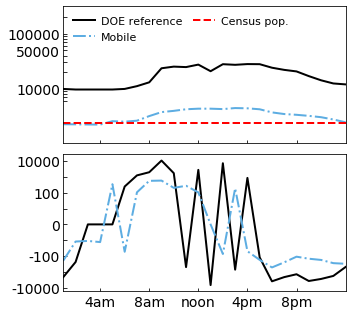

In [29]:
import matplotlib.ticker
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'in', 'xtick.major.size': 4.0, 'ytick.direction': 'in', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.})
fs = 14
hours = np.arange(1,25)

logOccOrig = np.log10(np.sum(occ_Orig_abs, axis=0))
logOccNew = np.log10(np.sum(occ_New_abs, axis=0))[0]

# look at the occupancies
fig, ax = plt.subplots(2,1, sharex='col', sharey='row', figsize=(5,4.5))
ax1 = ax[0]
ax1.tick_params(axis='both', which='major', labelsize=fs)
l1, = ax1.plot(hours, logOccOrig, color='k', linewidth=2)
ax1.set_xticks(np.arange(4,24,4))
ax1.set_xticklabels(['4am','8am', 'noon', '4pm', '8pm'])
ax1.tick_params(axis='both', which='major', labelsize=fs)

l2, = ax1.plot(hours, logOccNew, color='#5DADE2', linestyle='-.', linewidth=2)
l3, = ax1.plot([hours[0], hours[-1]],np.log10([totPop, totPop]),color='r',linestyle='--', linewidth=2)
ax1.set_xlim([1,24])
ax1.legend([l1,l2,l3],['DOE reference', 'Mobile', 'Census pop.'], fontsize=fs-3,loc='upper left', \
           ncol=2, handletextpad=0.5, columnspacing=1, frameon=False)

tickys = [np.log10(x) for x in np.asarray([6000, 7000,8000,9000, 10000,20000,30000,40000,\
                                           50000,60000,70000,80000,90000,100000,200000])]
ax1.set_yticks(tickys)
ax1.set_yticklabels(['','','','','10000','','','','50000','','','','','100000',''])
ax1.set_ylim([3,5.5])

occDiffOrig = np.zeros(np.shape(logOccOrig))
occDiffOrig[0] = np.sum(occ_Orig_abs, axis=0)[0]-np.sum(occ_Orig_abs, axis=0)[-1]
occDiffOrig[1:] = np.diff(np.sum(occ_Orig_abs, axis=0))
occDiffOrig[occDiffOrig>0]=np.log10(occDiffOrig[occDiffOrig>0])
occDiffOrig[occDiffOrig<0]=-np.log10(-occDiffOrig[occDiffOrig<0])
occDiffNew = np.zeros(np.shape(logOccNew))
occDiffNew[0] = np.sum(occ_New_abs, axis=0)[0][0]-np.sum(occ_New_abs, axis=0)[0][-1]
occDiffNew[1:] = np.diff(np.sum(occ_New_abs, axis=0)[0])
occDiffNew[occDiffNew>0]=np.log10(occDiffNew[occDiffNew>0])
occDiffNew[occDiffNew<0]=-np.log10(-occDiffNew[occDiffNew<0])
ax1 = ax[1]
ax1.tick_params(axis='both', which='major', labelsize=fs)
l1, = ax1.plot(hours, occDiffOrig, color='k', linewidth=2)
l1, = ax1.plot(hours, occDiffNew, color='#5DADE2', linestyle='-.', linewidth=2)
ax1.set_xticks(np.arange(4,24,4))
ax1.set_xticklabels(['4am','8am', 'noon', '4pm', '8pm'])
ax1.tick_params(axis='both', which='major', labelsize=fs)
tickys = [-4,-3,-2,-1,0,1,2,3,4]
ax1.set_yticks(tickys)
ax1.set_yticklabels(['-10000','','-100','','0','','100','','10000'])

fig.tight_layout()
# fig.savefig('../Useful_Results/totOcc.png', dpi=300, format='png',  bbox_inches='tight')

In [ ]:
min(np.sum(occ_Orig_abs, axis=0)), max(np.sum(occ_Orig_abs, axis=0)), \
min(np.sum(occ_New_abs, axis=0)[0]), max(np.sum(occ_New_abs, axis=0)[0])

In [1]:
totPop

NameError: name 'totPop' is not defined

In [30]:
class stayClass(object):
    def __init__(self, line):
        self.startTime = int(line[0])
        self.type = line[1]
        self.lat = float(line[3])
        self.lng = float(line[2])
        self.endTime = None
        self.userId = None
        self.building = None
        self.id = None
        self.previousId = None
    def __str__(self):
        printingArray = ['Start Time : ', self.startTime, '\n', \
                         'End Time : ', self.endTime, '\n', \
                         'Stay type : ', self.type,'\n', \
                         'Trip Location : ', self.lat, ', ', self.lng, '\n',
                         'Building : ', self.building, '\n', \
                         'User Id : ', self.userId]
        printingArray = [str(x) for x in printingArray]
        p = ''.join(printingArray)
        return p

In [31]:
stayLists = []
with open('../Data/demoTractUserStays.csv', 'r') as readFile:
    previousTrip = None
    counter = 0
    usersProcessed = 0
    stayList = []
    for line in readFile:
        counter+=1
#         print line.strip().split(' ')[0]
        line = line.strip().split(' ')
        if len(line)==1:
            if stayList:
                stayList = np.asarray(stayList)
                stayLists.append(stayList)

            usersProcessed+=1
            if usersProcessed%10000==0:
                print usersProcessed
            # New user
            # userId = int(line[0].split('-')[0])
            stayList = []
        else:
            previousTrip = stayClass(line)
            stayList.append([previousTrip.lng, previousTrip.lat, np.float(line[0])])
#             print [previousTrip.lng, previousTrip.lat, np.float(line[0])]

10000


In [32]:
# color the lines by the distance
import matplotlib.colors as colors2
import matplotlib.cm as cmx
minVal, maxVal = 0., 60.
cmOcc = plt.cm.get_cmap('spring')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

In [33]:
import math
def get_dist(p1,p2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = math.radians(p1[1])
    lon1 = math.radians(p1[0])
    lat2 = math.radians(p2[1])
    lon2 = math.radians(p2[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c

#     print("Result:", distance, "km")
    return distance

def pointInsidePolygon(point, polygon):
    X = [x[0] for x in polygon]
    Y = [x[1] for x in polygon]
    if point[0]>=min(X) and point[0]<=max(X) and \
       point[1]>=min(Y) and point[1]<=max(Y):
        polygon = mplPath.Path(np.array(polygon))
        return polygon.contains_point(point)
    else:
        return 0

In [34]:
noSamps = np.int(np.round(usersProcessed/50.))
userIndices = np.random.randint(0,usersProcessed,noSamps)

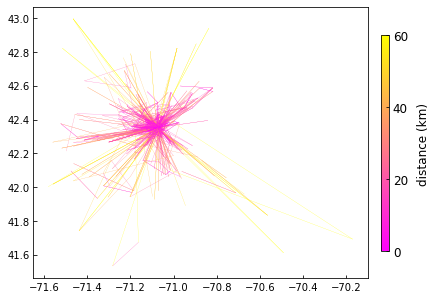

In [35]:
fig = plt.figure(figsize=(6,5))
ax1 = fig.add_subplot(111) 
for j, number in enumerate(userIndices): 
   
    for pointIndex in range(len(stayLists[number])-1):
        crowFlies = get_dist(stayLists[number][pointIndex,0:2],stayLists[number][pointIndex+1,0:2])
        cl = scalarMap3.to_rgba(crowFlies)
        cl = colors2.rgb2hex(cl)
        x = [stayLists[number][pointIndex,0], stayLists[number][pointIndex+1,0]]
        y = [stayLists[number][pointIndex,1], stayLists[number][pointIndex+1,1]]
        ax1.plot(x,y,linewidth=0.2,color=cl)
    for pointIndex in range(len(stayLists[number])-1):
        crowFlies = get_dist(stayLists[number][pointIndex,0:2],stayLists[number][pointIndex+1,0:2])
        cl = scalarMap3.to_rgba(crowFlies)
        cl = colors2.rgb2hex(cl)            

cbar_ax = plt.axes([0.93, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,60,10), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=12)
cbar.set_label('distance (km)', labelpad=9, rotation=90, fontsize=12)
cbar.set_ticks([0,20,40,60])
# cbar.set_ticklabels(['0','20'])

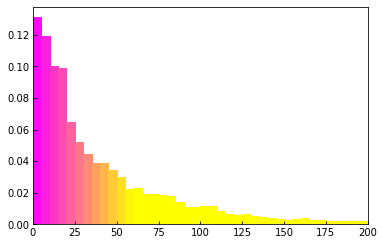

In [36]:
userDistances = np.zeros(len(stayLists))
for j in range(len(stayLists)): 
    for pointIndex in range(len(stayLists[j])-1):
        crowFlies = get_dist(stayLists[j][pointIndex,0:2],stayLists[j][pointIndex+1,0:2])
        userDistances[j]+=crowFlies
        
fig = plt.figure()
ax1 = fig.add_subplot(111)
binsDist = np.arange(0,200.1,5)
hist, edges = np.histogram(userDistances, bins=binsDist, density=False)
widthsDist = edges[1:]-edges[0:-1]
midpoints = edges[0:-1]+widthsDist/2.
bars = ax1.bar(midpoints,hist/np.float(np.sum(hist)),width=widthsDist)
ax1.set_xlim([0,200])
for j in range(len(bars)):
    cl = scalarMap3.to_rgba(midpoints[j])
    cl = colors2.rgb2hex(cl) 
    bars[j].set_color(cl)

In [37]:
nonLinParams = np.arange(0,1.01,.1)

Text(-0.15,0.05,'P(Mean occupied fraction)')

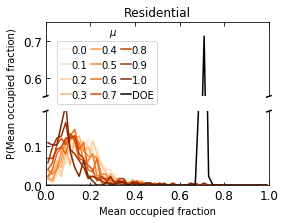

In [38]:
### plot the average fraction occupied for both RES and COMM
minVal, maxVal = -1, 10.
cmRes, cmComm = plt.cm.get_cmap('Oranges'), plt.cm.get_cmap('Blues')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMapRes, scalarMapComm = cmx.ScalarMappable(norm=cNorm, cmap=cmRes), \
                            cmx.ScalarMappable(norm=cNorm, cmap=cmComm)
scalarMapRes._A, scalarMapComm._A = [], []

t = tracts[0]
fig, ax = plt.subplots(2,1,sharex=True, sharey=False)
axs = ax.ravel()
fig.set_size_inches(4,3)

lines = []
labels = [[] for j in range(11)]

for j in range(11):
    cl1 = scalarMapRes.to_rgba((np.float(j)))
    cl2 = scalarMapComm.to_rgba((np.float(j)))
    cl = [colors2.rgb2hex(cl1), colors2.rgb2hex(cl2)]
    differencesRES, differencesNR = [], []
    for bID in allTestBuildings:
        uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
        if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
            differencesRES.append( \
            np.mean(SDLBuildings[bID]['total_occupancy24'][j])/max(allTestBuildings[bID]['total_occupancy']) )
        elif sum([1 for x in uses if x=='RESIDENT']) == 0:
            differencesNR.append( \
            np.mean(SDLBuildings[bID]['total_occupancy24'][j])/max(allTestBuildings[bID]['total_occupancy']) )

    diffBins = np.arange(0,1.01,0.02)
    diffResHist, diffResEdges = np.histogram( differencesRES, diffBins, density=False)
    diffCommHist, diffCommEdges = np.histogram( differencesNR, diffBins, density=False)
    diffResWidths = diffResEdges[1:]-diffResEdges[:-1]
    diffCommWidths = diffCommEdges[1:]-diffCommEdges[:-1]
    
    histsL = [diffResHist,diffCommHist]
    edgesL = [diffResEdges, diffCommEdges]
    widthsL = [diffResWidths, diffCommWidths]

    for axInd in range(1):
        l1, = axs[axInd].plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
                histsL[axInd]/np.float(np.sum(histsL[axInd])), color=cl[axInd])
        axs[axInd].tick_params(axis='both', labelsize=12)
        axs[axInd+1].plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
                histsL[axInd]/np.float(np.sum(histsL[axInd])), color=cl[axInd])
        axs[axInd+1].tick_params(axis='both', labelsize=12)
        
        lines.append(l1)
        labels[j]='%.1f'%(nonLinParams[j])
        
differencesRES, differencesNR = [], []
for bID in allTestBuildings:
    uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
    if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
        differencesRES.append( \
        np.mean(allTestBuildings[bID]['total_occupancy'])/max(allTestBuildings[bID]['total_occupancy']) )
    elif sum([1 for x in uses if x=='RESIDENT']) == 0:
        differencesNR.append( \
        np.mean(allTestBuildings[bID]['total_occupancy'])/max(allTestBuildings[bID]['total_occupancy']) )
        
diffBins = np.arange(0,1.01,0.02)
diffResHist, diffResEdges = np.histogram( differencesRES, diffBins, density=False)
diffCommHist, diffCommEdges = np.histogram( differencesNR, diffBins, density=False)
diffResWidths = diffResEdges[1:]-diffResEdges[:-1]
diffCommWidths = diffCommEdges[1:]-diffCommEdges[:-1]

histsL = [diffResHist,diffCommHist]
edgesL = [diffResEdges, diffCommEdges]
widthsL = [diffResWidths, diffCommWidths]

for axInd in range(1):
    l1, = axs[axInd].plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
            histsL[axInd]/np.float(np.sum(histsL[axInd])), color='k')
    axs[axInd+1].plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
            histsL[axInd]/np.float(np.sum(histsL[axInd])), color='k')
    axs[axInd].set_ylim([0.55, 0.75])  # outliers only
    axs[axInd+1].set_ylim([0, 0.19])  # outliers only
axs[0].set_xlim([0,1])
lines.append(l1)
labels.append('DOE')

# hide the spines between ax and ax2
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax[0].legend(lines,labels,ncol=3,handletextpad=0.1,handlelength=1,loc=[0.05, -0.1],columnspacing=0.3)
ax[0].text(0.3, 0.85,r'$\mu$', ha='center', va='center', transform=ax[0].transAxes)
ax[0].set_title('Residential')
ax[1].set_xlabel('Mean occupied fraction')
ax[0].text(-0.15, 0.05,'P(Mean occupied fraction)', ha='center', va='center', transform=ax[0].transAxes,rotation=90)
# fig.savefig('../Useful_Results/RESsensitivityVsDOE.png', dpi=300, format='png',  bbox_inches='tight')

Text(0.5,0,'Mean occupied fraction')

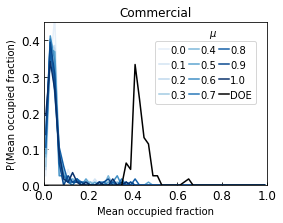

In [39]:
fig, axs = plt.subplots(1,1,sharex=True, sharey=False)
# axs = ax.ravel()
fig.set_size_inches(4,3)

lines = []
labels = [[] for j in range(11)]

for j in range(11):
    cl2 = scalarMapComm.to_rgba((np.float(j)))
    cl = [colors2.rgb2hex(cl1), colors2.rgb2hex(cl2)]
    differencesRES, differencesNR = [], []
    for bID in allTestBuildings:
        uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
        if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
            differencesRES.append( \
            np.mean(SDLBuildings[bID]['total_occupancy24'][j])/max(allTestBuildings[bID]['total_occupancy']) )
        elif sum([1 for x in uses if x=='RESIDENT']) == 0:
            differencesNR.append( \
            np.mean(SDLBuildings[bID]['total_occupancy24'][j])/max(allTestBuildings[bID]['total_occupancy']) )

    diffBins = np.arange(0,1.01,0.02)
    diffResHist, diffResEdges = np.histogram( differencesRES, diffBins, density=False)
    diffCommHist, diffCommEdges = np.histogram( differencesNR, diffBins, density=False)
    diffResWidths = diffResEdges[1:]-diffResEdges[:-1]
    diffCommWidths = diffCommEdges[1:]-diffCommEdges[:-1]
    
    histsL = [diffCommHist]
    edgesL = [diffCommEdges]
    widthsL = [diffCommWidths]
    axInd = 0
    l1, = axs.plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
            histsL[axInd]/np.float(np.sum(histsL[axInd])), color=cl[1])
    axs.tick_params(axis='both', labelsize=12)
    lines.append(l1)
    labels[j]='%.1f'%(nonLinParams[j])

differencesRES, differencesNR = [], []
for bID in allTestBuildings:
    uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
    if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
        differencesRES.append( \
        np.mean(allTestBuildings[bID]['total_occupancy'])/max(allTestBuildings[bID]['total_occupancy']) )
    elif sum([1 for x in uses if x=='RESIDENT']) == 0:
        differencesNR.append( \
        np.mean(allTestBuildings[bID]['total_occupancy'])/max(allTestBuildings[bID]['total_occupancy']) )
        
diffBins = np.arange(0,1.01,0.02)
diffResHist, diffResEdges = np.histogram( differencesRES, diffBins, density=False)
diffCommHist, diffCommEdges = np.histogram( differencesNR, diffBins, density=False)
diffResWidths = diffResEdges[1:]-diffResEdges[:-1]
diffCommWidths = diffCommEdges[1:]-diffCommEdges[:-1]

histsL = [diffCommHist]
edgesL = [diffCommEdges]
widthsL = [diffCommWidths]

l1, = axs.plot(edgesL[axInd][:-1]+widthsL[axInd]/2, \
        histsL[axInd]/np.float(np.sum(histsL[axInd])), color='k')
axs.set_ylim([0, 0.45])  # outliers only
axs.set_xlim([0,1])
lines.append(l1)
labels.append('DOE')

axs.legend(lines,labels,ncol=3,handletextpad=0.1,handlelength=1,loc=[0.5, 0.5],columnspacing=0.3)
axs.text(0.76, 0.93,r'$\mu$', ha='center', va='center', transform=axs.transAxes)
axs.set_title('Commercial')
axs.set_ylabel('P(Mean occupied fraction)')
axs.set_xlabel('Mean occupied fraction')
# fig.savefig('../Useful_Results/COMsensitivityVsDOE.png', dpi=300, format='png',  bbox_inches='tight')

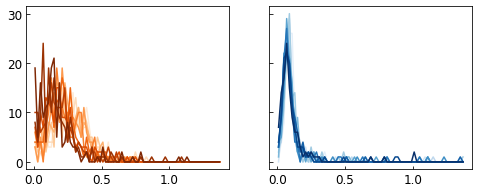

In [40]:
### plot the average fraction OF THE DOE OCCUPANCY for both RES and COMM
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
axs = ax.ravel()
fig.set_size_inches(8,3)

for j in range(11):
    cl1 = scalarMapRes.to_rgba((np.float(j)))
    cl2 = scalarMapComm.to_rgba((np.float(j)))
    cl = [colors2.rgb2hex(cl1), colors2.rgb2hex(cl2)]
    differencesRES, differencesNR = [], []
    for bID in allTestBuildings:
        uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
        newOcc = SDLBuildings[bID]['total_occupancy24'][j]
        oldOcc = allTestBuildings[bID]['total_occupancy']
        if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
            differencesRES.append( np.mean( np.divide( \
                newOcc[np.where(oldOcc>0)[0]],oldOcc[np.where(oldOcc>0)[0]]) ) )
        elif sum([1 for x in uses if x=='RESIDENT']) == 0:
            differencesNR.append( np.mean( np.divide( \
                newOcc[np.where(oldOcc>0)[0]],oldOcc[np.where(oldOcc>0)[0]]) ) )

    diffBins = np.arange(0,1.4,0.02)
    diffResHist, diffResEdges = np.histogram( differencesRES, diffBins, density=False)
    diffCommHist, diffCommEdges = np.histogram( differencesNR, diffBins, density=False)
    diffResWidths = diffResEdges[1:]-diffResEdges[:-1]
    diffCommWidths = diffCommEdges[1:]-diffCommEdges[:-1]

    for axInd in range(2):
        if axInd==0:
            axs[axInd].plot(diffResEdges[:-1]+diffResWidths/2, diffResHist, color=cl[axInd])
        else:
            axs[axInd].plot(diffCommEdges[:-1]+diffCommWidths/2, diffCommHist, color=cl[axInd])
        axs[axInd].tick_params(axis='both', labelsize=12)

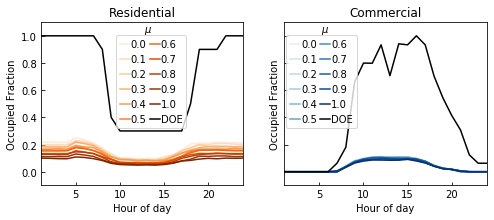

In [41]:
### plot the average fraction OF THE DOE OCCUPANCY for both RES and COMM
fig, ax = plt.subplots(1,2,sharex=True, sharey=True)
axs = ax.ravel()
fig.set_size_inches(8,3)

lines = [[] for j in range(2)]
labels = [[] for j in range(11)]

for j in range(11):
    cl1 = scalarMapRes.to_rgba((np.float(j)))
    cl2 = scalarMapComm.to_rgba((np.float(j)))
    cl = [colors2.rgb2hex(cl1), colors2.rgb2hex(cl2)]
    newRes, oldRes, newComm, oldComm = [], [], [], []
    for bID in allTestBuildings:
        uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
        newOcc = SDLBuildings[bID]['total_occupancy24'][j]
        oldOcc = allTestBuildings[bID]['total_occupancy']
        if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
            newRes.append( \
            newOcc/max(oldOcc) )
            if j ==10:
                oldRes.append( \
                oldOcc/max(oldOcc) )
        elif sum([1 for x in uses if x=='RESIDENT']) == 0:
            newComm.append( \
            newOcc/max(oldOcc) )
            if j==10:
                oldComm.append( \
                oldOcc/max(oldOcc) )
                
    # get the average occ
    avOcc = [np.median(newRes, axis=0), np.median(newComm, axis=0)]

    for axInd in range(2):
        l1, = axs[axInd].plot(np.arange(1,24.2), avOcc[axInd], color=cl[axInd])
        lines[axInd].append(l1)
    labels[j]='%.1f'%(nonLinParams[j])
        
avOcc = [np.median(oldRes, axis=0), np.median(oldComm, axis=0)]
titles = ['Residential','Commercial']
for axInd in range(2):
    l1, = axs[axInd].plot(np.arange(1,24.2), avOcc[axInd], color='k')
    axs[axInd].set_xlim([1,24])
    axs[axInd].set_ylim([-0.1,1.1])
    axs[axInd].set_xlabel('Hour of day')
    lines[axInd].append(l1)
    axs[axInd].set_ylabel('Occupied Fraction');
    axs[axInd].set_title(titles[axInd])
labels.append('DOE')

axs[0].legend(lines[0],labels,ncol=2,handletextpad=0.1,handlelength=1,loc=[0.37, 0.35],columnspacing=0.3)
axs[1].legend(lines[1],labels,ncol=2,handletextpad=0.1,handlelength=1,loc=[0.01, 0.35],columnspacing=0.3)
axs[0].text(0.53, 0.95,r'$\mu$', ha='center', va='center', transform=axs[0].transAxes);
axs[1].text(0.2, 0.95,r'$\mu$', ha='center', va='center', transform=axs[1].transAxes);
# fig.savefig('../Useful_Results/meanDayOccupiedFraction.png', dpi=300, format='png',  bbox_inches='tight')

In [42]:
allUses = []
for bID in allTestBuildings:
    usesSet = set([z for z in allTestBuildings[bID]['zoneUses']])
    for uS in usesSet:
        if uS not in allUses:
            allUses.append( uS )    
print allUses

[u'AppM', u'OffM', u'RetS', u'ReSd', u'Gara', u'OffL', u'HotL', u'HotS']


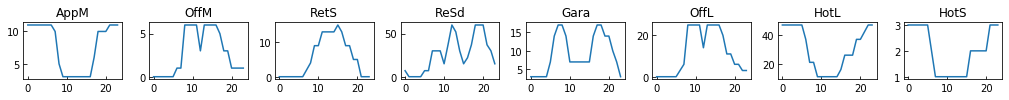

In [43]:
diffBuildings = [u'HotS', u'Mall', u'Gara', u'RetS', u'AppM', u'HotL', u'OffM', u'OffL', u'ReSd']
fig = plt.figure()
fig.set_size_inches(16,1.5)
axs = []
for d in range(len(allUses)):
    axs.append( fig.add_subplot(1,9,d+1) )
for jjj, bType in enumerate(allUses):
    for bID in allTestBuildings:
        usesSet = set([z for z in allTestBuildings[bID]['zoneUses']])
        if bType in usesSet:
            #print bID
            bIndex = allTestBuildings[bID]['zoneUses'].index( bType )
            mfFactor = allTestBuildings[bID]['zoneAreas'][bIndex] * allTestBuildings[bID]['peoplePerAreaZone'][bIndex]
            #print mfFactor
            occupancy = [np.round(x*mfFactor) for x in allTestBuildings[bID]['occs'][ allTestBuildings[bID]['useToSchedule'][bType] ] ]
            axs[jjj].plot(np.arange(0,24), occupancy)
            axs[jjj].set_title(bType)

            break   
fig.tight_layout()

In [44]:
testMuValues = np.asarray([0,0.5,1.])
testMuIndices = np.zeros(np.shape(testMuValues))
for j,mu in enumerate(testMuValues):
    testMuIndices[j] = np.where(np.round(nonLinParams,3)==np.round(mu,3))[0][0]
testMuIndices

array([ 0.,  5., 10.])

In [45]:
# plot the average hourly difference in occupancy between ref and mob
differencesRES1 = [[] for j in range(len(testMuValues))]
differencesRES2 = [[] for j in range(len(testMuValues))]
differencesNR1 = [[] for j in range(len(testMuValues))]
differencesNR2 = [[] for j in range(len(testMuValues))]
for bID in allTestBuildings:
    uses = [schedUsetoSDLUse[x] for x in allTestBuildings[bID]['zoneUses']]
    for j, muIndex in enumerate(testMuIndices):
        muIndex = int(muIndex)
        if sum([1 for x in uses if x=='RESIDENT'])==len(uses):
            if np.mean(allTestBuildings[bID]['total_occupancy'])>\
            np.mean(SDLBuildings[bID]['total_occupancy24'][muIndex]):
                differencesRES1[j].append(np.mean( np.absolute(allTestBuildings[bID]['total_occupancy'] \
                                    - SDLBuildings[bID]['total_occupancy24'][muIndex]) ))
            else:
                differencesRES2[j].append(np.mean( np.absolute(allTestBuildings[bID]['total_occupancy']\
                                    - SDLBuildings[bID]['total_occupancy24'][muIndex]) ))
        elif sum([1 for x in uses if x=='RESIDENT']) == 0:
            if np.mean(allTestBuildings[bID]['total_occupancy'])>\
            np.mean(SDLBuildings[bID]['total_occupancy24'][muIndex]):
                differencesNR1[j].append(np.mean(np.absolute(allTestBuildings[bID]['total_occupancy']\
                                    - SDLBuildings[bID]['total_occupancy24'][muIndex]) ))
            else:
                differencesNR2[j].append(np.mean( np.absolute(allTestBuildings[bID]['total_occupancy']\
                                    - SDLBuildings[bID]['total_occupancy24'][muIndex]) ))
print 'There are', len(differencesRES1[0])+len(differencesRES2[0]), 'buildings with res'
print 'There are', len(differencesNR1[0])+len(differencesNR2[0]), 'buildings with no res'

There are 174 buildings with res
There are 114 buildings with no res


In [46]:
start = [1,10,100,1000]
logTicks = []
for j in range(4):
    logTicks.append(np.arange(start[j],10*start[j],start[j]))
    
logTicks = np.log10(np.ravel(logTicks))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


Text(0,0.5,'P(Mean hourly occ. difference)')

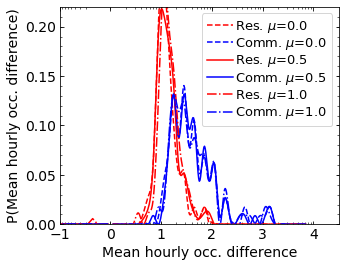

In [47]:
# plot the average hourly difference in occupancy between ref and mob
from scipy.interpolate import spline
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
lineStyles = ['--','-','-.']
diffBins = np.arange(0,4,0.1)
labels = []
lines = []
for plotIndex,muIndex in enumerate(testMuIndices):
    diffHist1, diffEdges = np.histogram( [np.log10(x) for x in differencesRES1[plotIndex]], diffBins, density=False)
    diffHist2, diffEdges = np.histogram( [np.log10(x) for x in differencesRES2[plotIndex]], diffBins, density=False)
    diffWidths = diffEdges[1:]-diffEdges[:-1]
    # interp 
    xvals = diffEdges[:-1]+diffWidths/2
    yvals = diffHist1/float(np.sum(diffHist1+diffHist2))
    xnew = np.linspace(xvals[0],xvals[-1],300)
    power_smooth = spline(xvals,yvals,xnew)
    l1, = ax1.plot(xnew, power_smooth,\
             color='r', linestyle=lineStyles[plotIndex])
    xvals = -diffEdges[:-1]-diffWidths/2
    yvals = diffHist2/float(np.sum(diffHist1+diffHist2))
    xnew = np.linspace(xvals[0],xvals[-1],300)
#     power_smooth = spline(xvals,yvals,xnew)
    l1, = ax1.plot(xvals, yvals,\
             color='r', linestyle=lineStyles[plotIndex])
    lines.append(l1)
    str111 = 'Res. $\mu$=%.1f'%nonLinParams[int(muIndex)]
    labels.append(str111)
    diffHist1, diffEdges = np.histogram( [np.log10(x) for x in differencesNR1[plotIndex]], diffBins, density=False)
    diffHist2, diffEdges = np.histogram( [np.log10(x) for x in differencesNR2[plotIndex]], diffBins, density=False)
    xvals = diffEdges[:-1]+diffWidths/2
    yvals = diffHist1/float(np.sum(diffHist1+diffHist2))
    xnew = np.linspace(xvals[0],xvals[-1],300)
    power_smooth = spline(xvals,yvals,xnew)
    l1, = ax1.plot(xnew, power_smooth, \
             color='b', linestyle=lineStyles[plotIndex])
    xvals = -diffEdges[:-1]-diffWidths/2
    yvals = diffHist2/float(np.sum(diffHist1+diffHist2))
    xnew = np.linspace(xvals[0],xvals[-1],300)
    power_smooth = spline(xvals,yvals,xnew)
    l1, = ax1.plot(-diffEdges[:-1]-diffWidths/2, diffHist2/float(np.sum(diffHist1+diffHist2)), \
             color='b', linestyle=lineStyles[plotIndex])
    lines.append(l1)
    str111 = 'Comm. $\mu$=%.1f'%nonLinParams[int(muIndex)]
    labels.append(str111)
    
ax1.legend(lines, labels, fontsize=fs-1, loc='upper right', ncol=1, handletextpad=0.2, labelspacing=0.1)
ax1.set_yticks(np.arange(0,0.21,0.05)), ax1.set_yticks(np.arange(0,0.22,0.01), minor=True)
ax1.set_xticks(np.arange(-1,4.5,1))
ax1.set_xticks(np.append(-logTicks[0:10][:1:-1],logTicks), minor=True)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='both', labelsize=fs)
ax1.set_xlim([-1,4.5])
ax1.set_ylim([0,0.22])
# ax1.set_xticklabels(['-10','0','10','100','1000','10000'])

ax1.set_xlabel(r'Mean hourly occ. difference',fontsize=fs)
ax1.set_ylabel(r'P(Mean hourly occ. difference)',fontsize=fs)
# fig.savefig('../Useful_Results/avHourDiff.png', dpi=300, format='png',  bbox_inches='tight')

In [48]:
def get_schedule_name_and_value(idf1, searchString):
    schedules = idf1.idfobjects['SCHEDULE:YEAR']
    sYToD = {}
    for s in schedules:
        if searchString in s.Name:
            sYToD[s.Name] = s.ScheduleWeek_Name_1
    
    schedules = idf1.idfobjects['SCHEDULE:WEEK:DAILY']
    for sh in sYToD:
        name = sYToD[sh]
        for s in schedules:
            if name == s.Name:
                sYToD[sh] = s.Monday_ScheduleDay_Name
    
    schedules = idf1.idfobjects['SCHEDULE:DAY:HOURLY']
    sNamToNum = {}
    for sh in sYToD:
        name = sYToD[sh]
        for s in schedules:
            if name == s.Name:
                sNamToNum[s.Name] = s['obj'][3:]
    
    return sYToD, sNamToNum

In [50]:
oldVals = {}
for f in fileList:
    idf1 = IDF(f)
    buildingID = f.split('files/')[1][:-4].split('_')[0]
    oldVals[buildingID] = {}
    # create a dictionary to store the zone info
    zoneNames = [ob.Name for ob in idf1.idfobjects['ZONE']]
    zoneObjects = idf1.idfobjects['ZONE']
    people = idf1.idfobjects['PEOPLE']
    lights = idf1.idfobjects['LIGHTS']
    equipment = idf1.idfobjects['ELECTRICEQUIPMENT']
    heat = idf1.idfobjects['ZONEHVAC:IDEALLOADSAIRSYSTEM']
    DHW = idf1.idfobjects['WATERUSE:EQUIPMENT']
    sheds = idf1.idfobjects['SCHEDULE:CONSTANT']
    oldVals[buildingID]['zones'] = {}
    for j,z in enumerate(zoneNames):
        str111 = 'z'+str(j)
        oldVals[buildingID]['zones'][str111] = {}
        oldVals[buildingID]['zones'][str111]['area'] = zoneObjects[j].Floor_Area
        oldVals[buildingID]['zones'][str111]['use'] = people[j].Number_of_People_Schedule_Name.split('B_')[1][0:4]
        oldVals[buildingID]['zones'][str111]['people']=people[j].Number_of_People_Schedule_Name
        oldVals[buildingID]['zones'][str111]['PCA']=people[j].People_per_Zone_Floor_Area
        oldVals[buildingID]['zones'][str111]['peakEqp']=equipment[j].Watts_per_Zone_Floor_Area
        oldVals[buildingID]['zones'][str111]['peakLights']=lights[j].Watts_per_Zone_Floor_Area
        for itemDHW in DHW:
            if z in itemDHW.Name:
                oldVals[buildingID]['zones'][str111]['flowRate']=itemDHW.Peak_Flow_Rate
                HotSupply = itemDHW.Hot_Water_Supply_Temperature_Schedule_Name
                ColdSupply = itemDHW.Cold_Water_Supply_Temperature_Schedule_Name        
                for sched in sheds:
                    if sched.Name == HotSupply:
                        oldVals[buildingID]['zones'][str111]['hotSupply'] = sched.Hourly_Value
                    if sched.Name == ColdSupply:
                        oldVals[buildingID]['zones'][str111]['coldSupply'] = sched.Hourly_Value
    # now get the schedules associated with that building
    
    oldVals[buildingID]['peopleSchedules'], oldVals[buildingID]['occupancy'] = \
    get_schedule_name_and_value(idf1, 'Occ')
        
    oldVals[buildingID]['lightSchedules'], oldVals[buildingID]['light'] = \
    get_schedule_name_and_value(idf1, 'Lgt')
    
    oldVals[buildingID]['eqpSchedules'], oldVals[buildingID]['eqp'] = \
    get_schedule_name_and_value(idf1, 'Eqp')
    
    oldVals[buildingID]['dhwSchedules'], oldVals[buildingID]['dhw'] = \
    get_schedule_name_and_value(idf1, 'DHW')
    
    oldVals[buildingID]['hetSchedules'], oldVals[buildingID]['het'] = \
    get_schedule_name_and_value(idf1, 'Het')
    
    oldVals[buildingID]['colSchedules'], oldVals[buildingID]['col'] = \
    get_schedule_name_and_value(idf1, 'Col')

In [51]:
# get total_occupancy per use
for j,b in enumerate(oldVals.keys()):
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])
    for use in usesSet:
        
        total_occ = np.zeros((24))
        for z in oldVals[b]['zones'].values():
            if use in z['people']:
                total_occ += np.asarray( oldVals[b]['occupancy'][oldVals[b]['peopleSchedules'][z['people']]] ) \
                            *z['area']*z['PCA']
        oldVals[b][use]=total_occ

In [52]:
f = open('../PickledData/UBEMdata/buildings.pickle', 'wb')
pickle.dump(oldVals, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [53]:
### skip the above 3 cells for just figure plotting if have already run the full script before
with open('../PickledData/UBEMdata/buildings.pickle', 'rb') as f:
    oldVals = pickle.load(f)

In [54]:
def scenario_1(oldSchedule, oldOccupancy, newOccupancy):
    newSchedule = np.zeros(np.shape(oldSchedule))
    for oi in range(len(newSchedule)):
        if oldOccupancy[oi]>0:
            if np.max(newOccupancy)>0:
                newSchedule[oi] = np.min(oldSchedule) + (oldSchedule[oi]-np.min(oldSchedule)) \
                *((newOccupancy[oi]/np.max(newOccupancy))/(oldOccupancy[oi]/np.max(oldOccupancy)))
            else:
                newSchedule[oi] = np.min(oldSchedule)
        else:
            newSchedule[oi] = np.min(oldSchedule)
        # if there are less people dont go above reference
        if oldOccupancy[oi]>=newOccupancy[oi]:
            if newSchedule[oi]>oldSchedule[oi]:
                newSchedule[oi] = oldSchedule[oi]
        # if there are more people dont go below reference
        if newOccupancy[oi]>oldOccupancy[oi]:
            if newSchedule[oi]<oldSchedule[oi]:
                newSchedule[oi] = oldSchedule[oi]
            # new can only scale above ref in proportion
            if newSchedule[oi]>oldSchedule[oi]*(newOccupancy[oi]/oldOccupancy[oi]):
                newSchedule[oi] = oldSchedule[oi]*(newOccupancy[oi]/oldOccupancy[oi])
            # limit the load so that it cannot be hogher unless people higher
            if np.max(oldOccupancy)>=np.max(newOccupancy):
                if newSchedule[oi]>np.max(oldSchedule):
                    newSchedule[oi] = np.max(oldSchedule)
        if np.isnan(newSchedule[oi]):
            print 'uh oh'
    return newSchedule

def scenario_2(oldSchedule, oldOccupancy, newOccupancy):
    newSchedule = np.zeros(np.shape(oldSchedule))
    for oi in range(len(newSchedule)):
        if oldOccupancy[oi]>0:
            if np.max(newOccupancy)>0:
                newSchedule[oi] = np.min(oldSchedule)+(oldSchedule[oi]-np.min(oldSchedule)) \
                *(newOccupancy[oi]/oldOccupancy[oi])
            else:
                newSchedule[oi] = np.min(oldSchedule)
            if np.max(oldOccupancy)>=np.max(newOccupancy):
                if newSchedule[oi]>np.max(oldSchedule):
                    newSchedule[oi] = np.max(oldSchedule)
        else:
            newSchedule[oi] = np.min(oldSchedule)
        if np.isnan(newSchedule[oi]):
            print 'uh oh'
    return newSchedule

In [55]:
## make some demos with buildings with different types
## demo for the following buildings
demos = [u'AppM', u'RetS', u'OffM', u'ReSd', u'HotL']
demoBuildings = [[] for j in range(len(demos))]
for j in range(len(demos)):
    for b in oldVals.keys():
        if demos[j] in [oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']]:
            demoBuildings[j] = b
            break
print demoBuildings

['0502876000', '0501338000', '0501242000', '0501401000', '0501344000']


## Decide which $\mu$ we want to run the energy simulations for

In [56]:
### we choose mu = 0.5, i.e. muIndex = 5
muIndex = 5

In [57]:
for building in SDLBuildings:
    SDLBuildings[building]['total_occupancy24'] = \
        SDLBuildings[building]['total_occupancy24'][muIndex]
    for key in SDLBuildings[building].keys():
        if key not in ['geometry', 'total_occupancy24']:
            SDLBuildings[building][key]['occupancy24'] = \
            SDLBuildings[building][key]['occupancy24'][muIndex]
            SDLBuildings[building][key]['occupancy'] = \
            SDLBuildings[building][key]['occupancy'][muIndex]

In [68]:
newTestUse = np.zeros((7,24))
counter = -1
for j,b in enumerate(demoBuildings):
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])   
    interestingUses = [x for x in usesSet if 'Ret' not in x]
    for use in interestingUses:
#         print use, SDLBuildings[b][schedUsetoSDLUse[use]]['occupancy24']
        counter+=1
        #print counter
        for hour, o in enumerate(SDLBuildings[b][schedUsetoSDLUse[use]]['occupancy24']):
            newTestUse[counter, hour] = o

In [75]:
# for each building and use, plot the occupancy, light, heat, DHW and cooling for each distinct use
# Illustrate different cases in Fig 4 occupancy
counter = -1
fs = 12
cols = ['#C0392B', '#5DADE2', '#F1C40F']
fig, ax = plt.subplots(5, 4, sharex='col')
fig.set_size_inches(10,10)
# limits=[[0,26],[0,13],[0,1800],[0,75],[0,600]]
# occMajorSteps = [5,5,500,50,200]
# occMinorSteps = [1,1,50,5,20]
for j,b in enumerate(demoBuildings):
    plts = ['light', 'eqp', 'dhw', 'het']
    colors = ['yellow','grey','orange','red']
    usesSet = set([oldVals[b]['zones'][z]['use'] for z in oldVals[b]['zones']])   
    interestingUses = [x for x in usesSet if 'Ret' not in x]
    for use in interestingUses:
        counter+=1

        newOccUse = newTestUse[counter,:]
        total_occ = np.zeros((24))
        for z in oldVals[b]['zones'].values():
            if use in z['people']:
                total_occ += np.asarray( oldVals[b]['occupancy'][oldVals[b]['peopleSchedules'][z['people']]] ) \
                            *z['area']*z['PCA']
        oldOccUse = np.round(total_occ)
        
        xnew = np.linspace(1, 24, num=100, endpoint=True)
        f = interp1d(hours, oldOccUse, kind='linear')
        oldOccInterp = f(xnew)
        if j in [0,1]:
            f = interp1d(hours, newOccUse, kind='linear')
        else:
            f = interp1d(hours, newOccUse, kind='cubic')
        newOccInterp = f(xnew)
        
        ax[j,0].plot(xnew, oldOccInterp, color='k', linewidth=1.5)
        ax[j,0].plot(xnew, newOccInterp, color=cols[1], linestyle='-.', linewidth=1.5)
        ax[j,0].set_xlim([1,24])
        #ax[j,0].set_ylim([limits[j][0],limits[j][1]])
        #ax[j,0].set_yticks(np.arange(0,limits[j][1],occMajorSteps[j]))
        #ax[j,0].set_yticks(np.arange(0,limits[j][1],occMinorSteps[j]), minor=True)
        ax[j,0].set_xticks(np.arange(6,24,6))
        ax[j,0].set_xticks(np.arange(2,24,2), minor=True)
        ax[j,0].set_ylabel('Occupancy (persons)')
        #ax[j,0].tick_params(axis='both', which='major', labelsize=fs)
        ax[j,0].tick_params(axis = 'both', which = 'minor', labelsize = 0)
        ax[j,0].set_xticklabels(['6am','noon','6pm'])

        schedNames = ['lightSchedules', 'eqpSchedules', 'dhwSchedules']
        lookupV = ['light', 'eqp', 'dhw']
        
        zVals = [z for z in oldVals[b]['zones'] if oldVals[b]['zones'][z]['use']==use]
                
        for sCount in range(3):
            actualSchedule = schedNames[sCount]
            k = [k for k in oldVals[b][actualSchedule].keys() if use in k][0]
            oldSchedule = oldVals[b][lookupV[sCount]][oldVals[b][actualSchedule][k]]
            
            newSchedule1 = scenario_1(oldSchedule, oldOccUse, newOccUse)
            
            newSchedule2 = scenario_2(oldSchedule, oldOccUse, newOccUse)
            
            plottedVals = np.zeros((3,24))
            plottedVals[0,:] = oldSchedule
            plottedVals[1,:] = newSchedule1
            plottedVals[2,:] = newSchedule2
            
            if actualSchedule=='lightSchedules':
                peak = [oldVals[b]['zones'][z]['peakLights'] for z in zVals]
                str111 = r'Peak: %.1f'%( np.mean(peak)*(np.max(plottedVals)/np.max(oldSchedule)) )\
                +' W/m$^{-2}$'
            elif actualSchedule == 'eqpSchedules':
                peak = [oldVals[b]['zones'][z]['peakEqp'] for z in zVals]
                str111 = r'Peak: %.1f'%( np.mean(peak)*(np.max(plottedVals)/np.max(oldSchedule)) )\
                +' W/m$^{-2} $'
            elif actualSchedule == 'dhwSchedules':
                peak = [oldVals[b]['zones'][z]['flowRate'] for z in zVals]
                str111 = 'Peak: %.1f'%( np.mean(peak)*1000000*(np.max(plottedVals)/np.max(oldSchedule)) )\
                +'X10$^{-6} $m$^{3}$/m$^{2}$'
                Tdiff = [(oldVals[b]['zones'][z]['hotSupply'] - oldVals[b]['zones'][z]['coldSupply']) for z in zVals]
                #print 'Peak Water = ', np.mean(peak)*np.mean(Tdiff)*1000*4.814

            colos = ['k', '#5DADE2', '#C0392B']
            stylers = ['-','-.','--']
            for scenario_i in range(3):
                f = interp1d(hours, plottedVals[scenario_i,:], kind='linear')
                schedulePlot = f(xnew)
                ax[j,sCount+1].plot(xnew, schedulePlot/np.max(plottedVals), color=colos[scenario_i]\
                                 , linewidth=1.5, linestyle=stylers[scenario_i])
            
            # graph format
            ax[j,sCount+1].text(2,1.05, str111)
            ax[j,sCount+1].set_ylabel('Fractional load')
            ax[j,sCount+1].set_xticks(np.arange(6,24,6))
            ax[j,sCount+1].set_xticks(np.arange(2,24,2), minor=True)
            ax[j,sCount+1].set_yticks(np.arange(0,1.8,0.4))
            ax[j,sCount+1].set_yticks(np.arange(0,1.8,0.1), minor=True)
            ax[j,sCount+1].set_xticklabels(['6am','noon','6pm'])
            ax[j,sCount+1].set_xlim([1,24]), ax[j,sCount+1].set_ylim([0,1.2])
        break
            
rL = mlines.Line2D([], [], color='k', linewidth=2, label='DOE ref.')
bL = mlines.Line2D([], [], color=cols[1], linestyle='-.', linewidth=1.5, label='Low impact')
yL = mlines.Line2D([], [], color=cols[0], linestyle='--',linewidth=1.5, label='High impact')
ax[0,1].legend(handles=[rL, bL, yL], fontsize=10, handletextpad=0.1, loc=[0,0.44])

rL = mlines.Line2D([], [], color='k', linewidth=1.5, label='DOE ref.')
bL = mlines.Line2D([], [], color=cols[1], linewidth=1.5, label='Mobile', linestyle='-.')
ax[0,0].legend(handles=[rL, bL], handletextpad=0.1, loc=[0.3,0.6])

fig.tight_layout()

Stuff that we need to save

In [74]:
try:
    f = open('../PickledData/UBEMdata/SDLBuildings.pickle', 'wb')
    pickle.dump(SDLBuildings, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise